In [1]:
import pyhere
import sys
sys.path.insert(0, str(pyhere.here().resolve().joinpath("src")))
import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, validation_curve, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

primary_fuel_transformed
Other                       18917
Solar                       10665
Wind                         5344
dtype: int64


<AxesSubplot:xlabel='primary_fuel_transformed'>

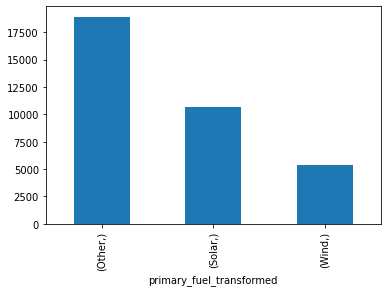

In [19]:
csv_power_plants = pd.read_csv(utils.DIR_DATA_INTERIM/"power_plants_with_generation_transformed.csv", index_col=[0])
# df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v2_transformed_data_combined_with_nasa.csv", index_col=['index'])
df_transformed = pd.read_csv(utils.DIR_DATA_EXTERNAL/"v5_transformed_data_combined_with_nasa.csv", index_col=['index'])
# csv_power_plants.loc[0:34935, ['capacity_mw', 'primary_fuel_transformed']].index.name = "index"
csv_power_plants.index.rename('index', inplace=True)
df_power_plants_raw = pd.read_csv(utils.DIR_DATA_RAW/"global_power_plant_database.csv", usecols=['name','primary_fuel', 'estimated_generation_gwh_2013'], engine='python')
csv_power_plants = csv_power_plants.join(df_power_plants_raw)

# index_set_to_delete = csv_power_plants[csv_power_plants['other_fuel1'].isin(['Solar', 'Wind'])].index.tolist()
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel2'].isin(['Solar', 'Wind'])].index.tolist())
# index_set_to_delete += (csv_power_plants[csv_power_plants['other_fuel3'].isin(['Solar', 'Wind'])].index.tolist())

# csv_power_plants.drop(index_set_to_delete, inplace = True)
columns_to_combine = [
                        'name',
                        'capacity_mw',
                        'primary_fuel_transformed',
                        # 'other_fuel1',
                        # 'other_fuel2',
                        # 'other_fuel3',
                        'generation_gwh_2013',
                        'generation_gwh_2014',
                        'generation_gwh_2015',
                        'generation_gwh_2016',
                        'generation_gwh_2017',
                        'generation_gwh_2018',
                        # 'estimated_generation_gwh_2013',
                        # 'generation_gwh_2019'
                    ]
# df_transformed_combined = df_transformed.merge(csv_power_plants.loc[0:24360, ['capacity_mw', 'primary_fuel_transformed']],left_on="index", right_on="index")
df_transformed_combined = df_transformed.merge(csv_power_plants[columns_to_combine],left_on="index", right_on="index")
print(df_transformed_combined[['primary_fuel_transformed']].value_counts())
df_transformed_combined[['primary_fuel_transformed']].value_counts().plot.bar()

In [20]:
df_solar = df_transformed_combined[df_transformed_combined['primary_fuel_transformed']== "Solar"]
df_solar = df_solar[~df_solar['name'].str.contains('CSP')]
df_solar

latitude  longitude  ANN_ALLSKY_SFC_LW_DWN_2013  \
index                                                    
1        31.670     65.795                      315.48   
2        31.623     65.792                      315.48   
17       27.908     -0.317                      355.96   
18       35.880      5.475                      323.29   
20       34.532      0.804                      317.57   
...         ...        ...                         ...   
34833    11.700    108.900                      385.23   
34847    11.446    108.866                      385.23   
34894    16.440    107.505                      419.30   
34895    11.700    109.030                      416.33   
34921   -15.550     28.350                      353.47   

       ANN_ALLSKY_SFC_LW_DWN_2014  ANN_ALLSKY_SFC_LW_DWN_2015  \
index                                                           
1                          312.10                      318.59   
2                          312.10                      318.59   
17                         359.55                      360.83   
18                         325.23                      325.22   
20                         321.81                      321.93   
...                           ...                         ...   
34833                      383.91                      383.59   
34847                      383.91                      383.59   
34894                      417.81                      417.75   
34895                      414.42                      413.69   
34921                      355.89                      354.27   

       ANN_ALLSKY_SFC_LW_DWN_2016  ANN_ALLSKY_SFC_LW_DWN_2017  \
index                                                           
1                          312.91                      312.98   
2                          312.91                      312.98   
17                         361.69                      359.83   
18                         326.49                      323.06   
20                         323.80                      323.66   
...                           ...                         ...   
34833                      389.36                      389.60   
34847                      389.36                      389.60   
34894                      423.10                      418.65   
34895                      418.23                      418.62   
34921                      357.60                      358.91   

       ANN_ALLSKY_SFC_LW_DWN_2018  ANN_ALLSKY_SFC_LW_DWN_2019  \
index                                                           
1                          315.31                      315.80   
2                          315.31                      315.80   
17                         358.59                      353.05   
18                         322.57                      322.19   
20                         318.45                      315.98   
...                           ...                         ...   
34833                      388.57                      386.47   
34847                      388.57                      386.47   
34894                      417.83                      421.23   
34895                      417.69                      417.07   
34921                      355.95                      354.70   

       ANN_ALLSKY_SFC_LW_UP_2013  ...  winter_WS50M_RANGE_AVG_2019  \
index                             ...                                
1                          10.41  ...                     6.300000   
2                          10.41  ...                     6.300000   
17                         11.13  ...                     5.710000   
18                          9.84  ...                     4.913333   
20                          9.62  ...                     5.453333   
...                          ...  ...                          ...   
34833                      10.55  ...                     2.240000   
34847                      10.55  ...                     2.240000   
34894         

In [17]:
df_solar_attempt = df_solar[df_solar['generation_gwh_2013'].isna() & df_solar['estimated_generation_gwh_2013'].notna()]
# df_solar_attempt.loc[:,['generation_gwh_2013']] = 23.23
# df_solar_attempt.loc[:,['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']].copy()
df_solar.loc[df_solar_attempt.index, ['generation_gwh_2013']] = df_solar_attempt.loc[:,['estimated_generation_gwh_2013']]

df_solar['generation_gwh_2013'].fillna(df_solar['estimated_generation_gwh_2013'], inplace=True)

# df_solar[df_solar['generation_gwh_2013'].isna()]

541
76


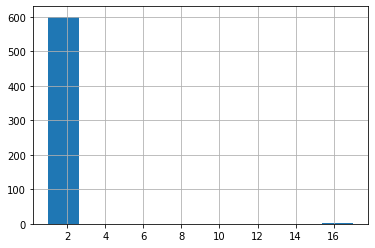

In [21]:
df_solar_alt = df_solar[df_solar['generation_gwh_2013'].notna()]
df_solar_alt['generation_gwh_2013'].value_counts().hist(bins=10)
print(df_solar_alt[df_solar_alt['generation_gwh_2013'] < 20]['generation_gwh_2013'].count())
print(df_solar_alt.loc[(df_solar_alt['generation_gwh_2013'] >= 20) & (df_solar_alt['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count())


<AxesSubplot:>

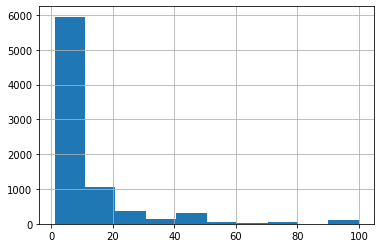

In [5]:

# df_solar_alt.loc[df_solar_alt['capacity_mw'] == (df_solar_alt['capacity_mw'].value_counts()>20)]
# indexes = df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()>20).index
# df_solar_alt['capacity_mw'].value_counts().values>20
# df_solar_alt.loc[indexes]['capacity_mw']
# df_solar_alt[df_solar_alt['capacity_mw'] == 145]
# df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)].capacity_mw
df_solar_alt_more_than_20 = df_solar_alt[df_solar_alt['capacity_mw'].isin(df_solar_alt['capacity_mw'].value_counts()[df_solar_alt['capacity_mw'].value_counts()>20].index)]
df_solar_alt_more_than_20['capacity_mw'].hist()

In [6]:
# utils.calculate_feature_mean_std(df_solar_alt)

In [64]:
# columns_delete = df_solar.columns.str.contains('WS') | df_solar.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') |  df_solar.columns.str.contains('ANN') |  df_solar.columns.str.contains('LW') |  df_solar.columns.str.contains('WS10') | df_solar.columns.str.contains('MAX')
# columns_delete = df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar.columns.str.contains('latitude') | df_solar.columns.str.contains('longitude') | df_solar.columns.str.contains('2019') | df_solar.columns.str.contains('2012') | df_solar.columns.str.contains('2013') | df_solar.columns.str.contains('2014') | df_solar.columns.str.contains('2015') | df_solar.columns.str.contains('2016') | df_solar.columns.str.contains('2017') | df_solar.columns.str.contains('2018') 
# columns_delete = df_solar_alt.columns.str.contains('2013') | df_solar_alt.columns.str.contains('generation_gwh_2013') | df_solar_alt.columns.str.contains('estimated_generation_gwh_2013') | df_solar_alt.columns.str.contains('WS') | df_solar_alt.columns.str.contains('name') | df_solar_alt.columns.str.contains('primary_fuel_transformed') | df_solar_alt.columns.str.contains('latitude') | df_solar_alt.columns.str.contains('longitude') | df_solar_alt.columns.str.contains('2019') | df_solar_alt.columns.str.contains('2012') | df_solar_alt.columns.str.contains('2014') | df_solar_alt.columns.str.contains('2015') | df_solar_alt.columns.str.contains('2016') | df_solar_alt.columns.str.contains('2017') | df_solar_alt.columns.str.contains('2018') 
columns_keep_2013 = df_solar_alt.columns.str.contains('2013') | df_solar_alt.columns.str.contains('capacity_mw')
columns_keep_2014 = df_solar_alt.columns.str.contains('2014') | df_solar_alt.columns.str.contains('capacity_mw')
columns_keep_2015 = df_solar_alt.columns.str.contains('2015') | df_solar_alt.columns.str.contains('capacity_mw')
columns_keep_2016 = df_solar_alt.columns.str.contains('2016') | df_solar_alt.columns.str.contains('capacity_mw')
columns_keep_2017 = df_solar_alt.columns.str.contains('2017') | df_solar_alt.columns.str.contains('capacity_mw')
columns_keep_2018 = df_solar_alt.columns.str.contains('2018') | df_solar_alt.columns.str.contains('capacity_mw')
# df_solar_2 = df_solar_alt_more_than_20.loc[:,~columns_delete]
# df_solar_2013 = df_solar_alt.loc[:,~columns_delete]
df_solar_2013 = df_solar_alt.loc[:,columns_keep_2013]
df_solar_2014 = df_solar_alt.loc[:,columns_keep_2014]
df_solar_2015 = df_solar_alt.loc[:,columns_keep_2015]
df_solar_2016 = df_solar_alt.loc[:,columns_keep_2016]
df_solar_2017 = df_solar_alt.loc[:,columns_keep_2017]
df_solar_2018 = df_solar_alt.loc[:,columns_keep_2018]
# columns_delete_2013 = df_solar_2013.columns.str.contains('WS')
df_solar_2013 = df_solar_2013.loc[:,~df_solar_2013.columns.str.contains('WS')]
df_solar_2014 = df_solar_2014.loc[:,~df_solar_2014.columns.str.contains('WS')]
df_solar_2015 = df_solar_2015.loc[:,~df_solar_2015.columns.str.contains('WS')]
df_solar_2016 = df_solar_2016.loc[:,~df_solar_2016.columns.str.contains('WS')]
df_solar_2017 = df_solar_2017.loc[:,~df_solar_2017.columns.str.contains('WS')]
df_solar_2018 = df_solar_2018.loc[:,~df_solar_2018.columns.str.contains('WS')]

In [69]:
dict_columns_2013 = {a:a.replace('_2013', '') for a in df_solar_2013.columns}
dict_columns_2014 = {a:a.replace('_2014', '') for a in df_solar_2014.columns}
dict_columns_2015 = {a:a.replace('_2015', '') for a in df_solar_2015.columns}
dict_columns_2016 = {a:a.replace('_2016', '') for a in df_solar_2016.columns}
dict_columns_2017 = {a:a.replace('_2017', '') for a in df_solar_2017.columns}
dict_columns_2018 = {a:a.replace('_2018', '') for a in df_solar_2018.columns}
df_solar_2013.rename(columns=dict_columns_2013, inplace=True)
df_solar_2014.rename(columns=dict_columns_2014, inplace=True)
df_solar_2015.rename(columns=dict_columns_2015, inplace=True)
df_solar_2016.rename(columns=dict_columns_2016, inplace=True)
df_solar_2017.rename(columns=dict_columns_2017, inplace=True)
df_solar_2018.rename(columns=dict_columns_2018, inplace=True)

In [72]:
df_solar_2013.head()

ANN_ALLSKY_SFC_LW_DWN  ANN_ALLSKY_SFC_LW_UP  ANN_ALLSKY_SFC_SW_DIFF  \
index                                                                        
794                   324.08                 10.43                    1.36   
24713                 317.53                  8.79                    1.62   
24715                 341.24                  9.54                    1.88   
24716                 317.53                  8.79                    1.62   
24719                 317.53                  8.79                    1.62   

       ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  ANN_ALLSKY_SFC_SW_UP  \
index                                                                       
794                     7.45                   5.79                  1.02   
24713                   4.28                   3.98                  0.52   
24715                   5.35                   5.04                  0.46   
24716                   4.28                   3.98                  0.52   
24719                   4.28                   3.98                  0.52   

       ANN_ALLSKY_SFC_SW_UP_MAX  ANN_CLRSKY_SFC_SW_DIFF  \
index                                                     
794                        1.82                    0.89   
24713                      1.23                    1.39   
24715                      0.96                    1.01   
24716                      1.23                    1.39   
24719                      1.23                    1.39   

       ANN_CLRSKY_SFC_SW_DNI  ANN_CLRSKY_SFC_SW_DWN  ...  \
index                                                ...   
794                     9.54                   6.54  ...   
24713                   7.24                   5.40  ...   
24715                   8.75                   6.18  ...   
24716                   7.24                   5.40  ...   
24719                   7.24                   5.40  ...   

       winter_ALLSKY_SFC_SW_DWN  winter_ALLSKY_SFC_SW_UP  \
index                                                      
794                    7.206667                 1.290000   
24713                  5.183333                 0.666667   
24715                  5.813333                 0.550000   
24716                  5.183333                 0.666667   
24719                  5.183333                 0.666667   

       winter_ALLSKY_SFC_SW_UP_MAX  winter_CLRSKY_SFC_SW_DIFF  \
index                                                           
794                       1.680000                   1.120000   
24713                     1.026667                   1.853333   
24715                     0.680000                   1.266667   
24716                     1.026667                   1.853333   
24719                     1.026667                   1.853333   

       winter_CLRSKY_SFC_SW_DNI  winter_CLRSKY_SFC_SW_DWN  \
index                                                       
794                       10.59                  8.070000   
24713                      7.50                  6.693333   
24715                      9.18                  7.366667   
24716                      7.50                  6.693333   
24719                      7.50                  6.693333   

       winter_CLRSKY_SFC_SW_UP  winter_T2M  capacity_mw  generation_gwh  
index                                                                    
794                   1.440000   25.440000        145.0        0.847778  
24713                 0.870000   21.703333          1.9        2.414610  
24715                 0.666667   23.150000          1.3        1.528000  
24716                 0.870000   21.666667          3.8        5.036000  
24719                 0.870000   21.666667          1.9        2.741000  

[5 rows x 62 columns]

In [87]:
df_solar_2014.reset_index().head()

index  ANN_ALLSKY_SFC_LW_DWN  ANN_ALLSKY_SFC_LW_UP  ANN_ALLSKY_SFC_SW_DIFF  \
0    794                 325.71                 10.44                    1.33   
1  24713                 316.16                  8.71                    1.64   
2  24715                 346.81                  9.77                    1.81   
3  24716                 316.16                  8.71                    1.64   
4  24719                 316.16                  8.71                    1.64   

   ANN_ALLSKY_SFC_SW_DNI  ANN_ALLSKY_SFC_SW_DWN  ANN_ALLSKY_SFC_SW_UP  \
0                   7.47                   5.74                  0.98   
1                   4.19                   3.98                  0.55   
2                   5.70                   5.29                  0.44   
3                   4.19                   3.98                  0.55   
4                   4.19                   3.98                  0.55   

   ANN_ALLSKY_SFC_SW_UP_MAX  ANN_CLRSKY_SFC_SW_DIFF  ANN_CLRSKY_SFC_SW_DNI  \
0                      1.72                    0.88                   9.53   
1                      1.48                    1.36                   7.31   
2                      0.83                    0.98                   8.78   
3                      1.48                    1.36                   7.31   
4                      1.48                    1.36                   7.31   

   ...  winter_ALLSKY_SFC_SW_DWN  winter_ALLSKY_SFC_SW_UP  \
0  ...                      7.16                 1.266667   
1  ...                      5.33                 0.666667   
2  ...                      6.42                 0.556667   
3  ...                      5.33                 0.666667   
4  ...                      5.33                 0.666667   

   winter_ALLSKY_SFC_SW_UP_MAX  winter_CLRSKY_SFC_SW_DIFF  \
0                     1.536667                   1.090000   
1                     1.056667                   1.816667   
2                     0.636667                   1.120000   
3                     1.056667                   1.816667   
4                     1.056667                   1.816667   

   winter_CLRSKY_SFC_SW_DNI  winter_CLRSKY_SFC_SW_DWN  \
0                 10.593333                  8.050000   
1                  7.543333                  6.710000   
2                  9.486667                  7.406667   
3                  7.543333                  6.710000   
4                  7.543333                  6.710000   

   winter_CLRSKY_SFC_SW_UP  winter_T2M  capacity_mw  generation_gwh  
0                 1.413333   26.183333        145.0        0.845278  
1                 0.846667   21.656667          1.9        2.350000  
2                 0.626667   23.840000          1.3        2.149000  
3                 0.846667   21.900000          3.8        4.524000  
4                 0.846667   21.900000          1.9        2.584000  

[5 rows x 63 columns]

In [93]:
df_all_concat = pd.concat([df_solar_2013,df_solar_2014,df_solar_2015,df_solar_2016,df_solar_2017,df_solar_2018])

In [96]:
df_all_concat.reset_index(drop=True, inplace = True)

In [100]:
df_all_concat['generation_gwh'].isna().sum()

23

# CORRELATION AND MUTUAL INFORMATION SCORES

In [8]:
df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

In [98]:
mi_scores = utils.make_mi_scores(df_all_concat.drop(columns=['generation_gwh']), df_all_concat[['generation_gwh']], "regression")

utils.plot_scores(mi_scores, "Mutual Information Regression")

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/sklearn/utils/validation.py:1107: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Input y contains NaN.

In [39]:
X = df_solar_2013.drop(columns=['generation_gwh_2013'])
# X = df_solar_2013[['generation_gwh_2013']]
y = df_solar_2013['generation_gwh_2013']
# y
selector = SelectKBest(mutual_info_regression, k= 2)
new_X = selector.fit_transform(X, y)
cols = selector.get_support(indices=True)
features_df_new = X.iloc[:,cols]

# # df_new_X = pd.DataFrame(new_X, index=new_X.index, columns=new_X.columns)
df_solar_2013_best_k = pd.concat([features_df_new,y], axis=1)
# df_solar_2013_best_k
# selector.scores_
# utils.plot_scores(selector.scores_, "Best K")
# plt.plot(selector.scores_)
# plt.xticks(np.arange(df_solar_2013.drop(columns=['generation_gwh_2013']).columns.len), list(df_solar_2013.drop(columns=['generation_gwh_2013']).columns))

In [40]:
df_solar_2013_best_k

ANN_CLRSKY_SFC_SW_DWN_2013  capacity_mw  generation_gwh_2013
index                                                              
794                          6.54        145.0             0.847778
24713                        5.40          1.9             2.414610
24715                        6.18          1.3             1.528000
24716                        5.40          3.8             5.036000
24719                        5.40          1.9             2.741000
...                           ...          ...                  ...
34465                        5.49         10.0            14.203000
34491                        5.28          1.0             1.341000
34492                        5.73          5.0             0.286000
34498                        5.40          3.6             5.467000
34512                        5.91          1.0             2.041000

[632 rows x 3 columns]

In [43]:
corr_matrix

ANN_CLRSKY_SFC_SW_DWN_2013  capacity_mw  \
ANN_CLRSKY_SFC_SW_DWN_2013                    1.000000     0.218641   
capacity_mw                                   0.218641     1.000000   
generation_gwh_2013                           0.222728     0.730858   

                            generation_gwh_2013  
ANN_CLRSKY_SFC_SW_DWN_2013             0.222728  
capacity_mw                            0.730858  
generation_gwh_2013                    1.000000

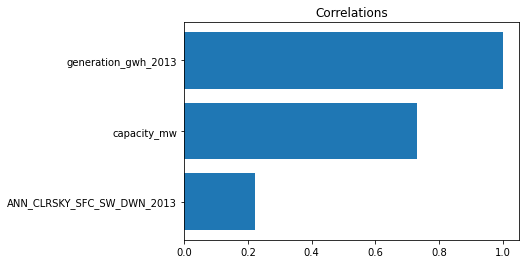

In [44]:
from matplotlib.pyplot import xlabel


# plt.bar(df_solar_2013_best_k.corr().abs().unstack()['capacity_mw'].sort_values(ascending=False), height=df_solar_2013_best_k.columns)
corr_matrix = df_solar_2013_best_k.corr().abs()



target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .20]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

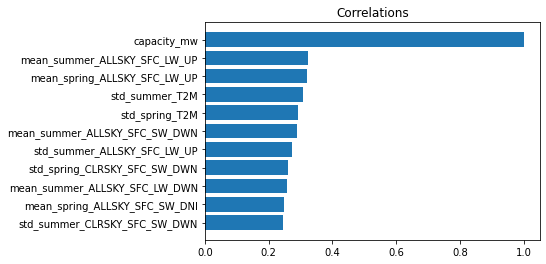

In [9]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df_solar_2.drop(columns=to_drop, inplace=True)

corr_matrix = df_solar_2.corr().abs()



target_correlations = corr_matrix.unstack()['capacity_mw'].sort_values(ascending=False)
# target_correlations = corr_matrix.unstack()['generation_gwh_2013'].sort_values(ascending=False)
target_correlations[target_correlations > .20]
# plt.figure(dpi=100, figsize=(4, 10))
utils.plot_scores(target_correlations[target_correlations > .20], "Correlations")

In [10]:
df_solar_2 = df_solar_2[target_correlations[target_correlations > .20].index]
df_solar_2

capacity_mw  mean_summer_ALLSKY_SFC_LW_UP  \
index                                              
1             10.0                     11.966667   
2             10.0                     11.966667   
17            20.0                      9.631111   
18            20.0                     11.496667   
20            20.0                     11.292222   
...            ...                           ...   
34790         30.0                     10.550000   
34795         49.0                     10.900000   
34796         10.0                     10.494444   
34894         48.0                     11.219444   
34921         47.5                     10.300556   

       mean_spring_ALLSKY_SFC_LW_UP  std_summer_T2M  std_spring_T2M  \
index                                                                 
1                         11.488333        0.334580        0.568469   
2                         11.488333        0.334580        0.568469   
17                        10.135556        0.628513        0.976169   
18                        10.470556        0.667055        0.808957   
20                        10.299444        0.823757        1.552828   
...                             ...             ...             ...   
34790                     10.728889        1.464394        1.515303   
34795                     11.173333        0.338115        0.722115   
34796                     10.517778        0.342312        0.703489   
34894                     11.207778        0.410774        0.871253   
34921                      9.885556        0.339245        0.362890   

       mean_summer_ALLSKY_SFC_SW_DWN  std_summer_ALLSKY_SFC_LW_UP  \
index                                                               
1                           7.516111                     0.059255   
2                           7.516111                     0.059255   
17                          5.350000                     0.084896   
18                          6.732222                     0.062004   
20                          6.698333                     0.084424   
...                              ...                          ...   
34790                       4.743889                     0.038873   
34795                       4.928889                     0.039101   
34796                       4.314444                     0.051668   
34894                       4.959444                     0.052426   
34921                       5.898889                     0.068033   

       std_spring_CLRSKY_SFC_SW_DWN  mean_summer_ALLSKY_SFC_LW_DWN  \
index                                                                
1                          0.089279                     349.195556   
2                          0.089279                     349.195556   
17                         0.064533                     303.821667   
18                         0.040974                     372.442778   
20                         0.072216                     370.066667   
...                             ...                            ...   
34790                      0.030822                     402.363333   
34795                      0.019255                     423.500556   
34796                      0.100607                     407.062222   
34894                      0.114523                     431.916667   
34921                      0.056125                     324.561667   

       mean_spring_ALLSKY_SFC_SW_DNI  std_summer_CLRSKY_SFC_SW_DWN  
index                                                               
1                           7.820556                      0.079873  
2                           7.820556                      0.079873  
17                          5.636111                      0.059092  
18                          6.558889                      0.054515  
20                          6.866667                      0.055474  
...                              ...                           ...  
34790                       4.023889         

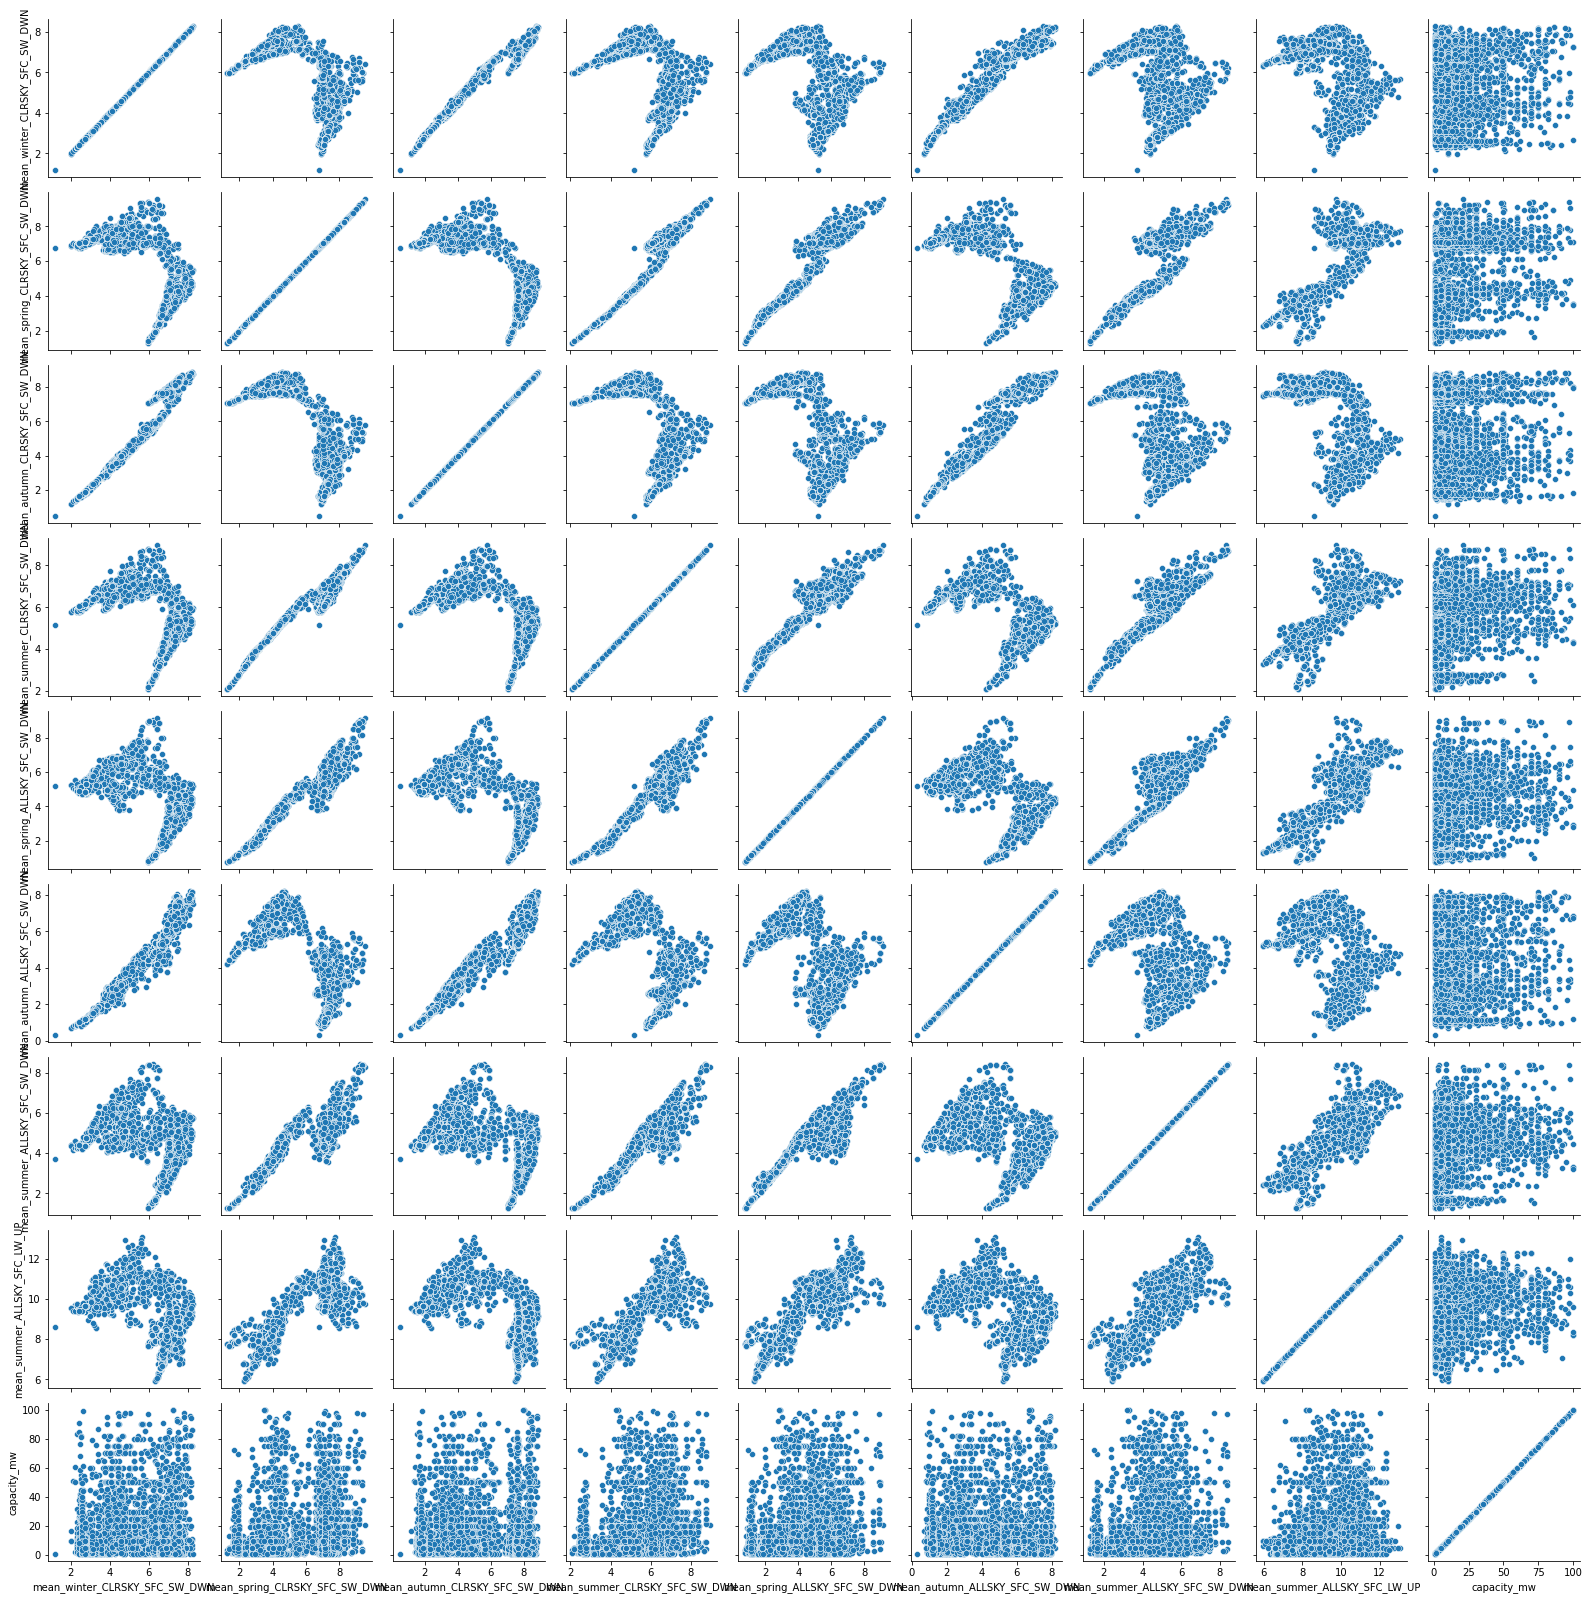

In [13]:
g = sns.PairGrid(df_solar_2_best_k)
# g = sns.PairGrid(df_solar_2)
g.map(sns.scatterplot)

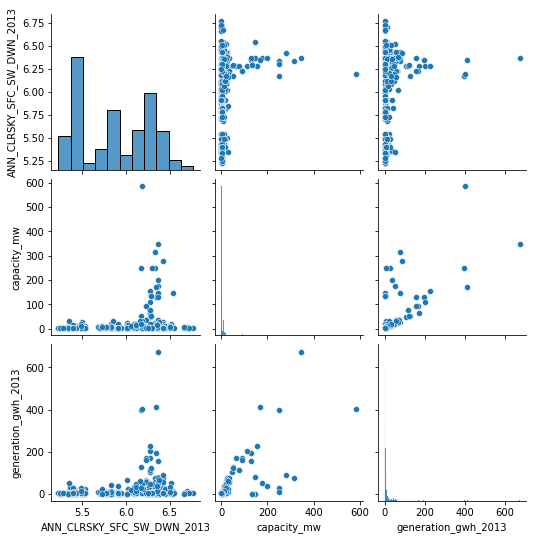

In [47]:
sns.pairplot(df_solar_2013_best_k)

In [15]:
X = df_solar_3.drop(columns=['capacity_mw'])
# X = df_solar_2[['capacity_mw']]
y = df_solar_3['capacity_mw']

min_max_scaler = MinMaxScaler()

power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()


x_scaled = min_max_scaler.fit_transform(X)
# x_scaled = power_transformer.fit_transform(X)
# x_scaled = standard_scaler.fit_transform(X)
df_X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)
df_solar_3_scaled = pd.concat([df_X_scaled,y], axis=1)
df_solar_3_scaled

mean_summer_ALLSKY_SFC_LW_UP  mean_spring_ALLSKY_SFC_LW_UP  \
index                                                               
1                          0.844693                      0.784959   
2                          0.844693                      0.784959   
17                         0.517585                      0.552855   
18                         0.778867                      0.610333   
20                         0.750233                      0.580974   
...                             ...                           ...   
34790                      0.646281                      0.654656   
34795                      0.695300                      0.730912   
34796                      0.638500                      0.618435   
34894                      0.740040                      0.736822   
34921                      0.611345                      0.509961   

       std_summer_T2M  std_spring_T2M  mean_summer_ALLSKY_SFC_SW_DWN  \
index                                                                  
1            0.087091        0.188524                       0.873463   
2            0.087091        0.188524                       0.873463   
17           0.181232        0.363429                       0.570039   
18           0.193576        0.291694                       0.763658   
20           0.243765        0.610818                       0.758911   
...               ...             ...                            ...   
34790        0.448948        0.594720                       0.485136   
34795        0.088223        0.254439                       0.511051   
34796        0.089567        0.246448                       0.424981   
34894        0.111494        0.318420                       0.515331   
34921        0.088585        0.100329                       0.646926   

       std_summer_ALLSKY_SFC_LW_UP  std_spring_CLRSKY_SFC_SW_DWN  \
index                                                              
1                         0.145592                      0.356668   
2                         0.145592                      0.356668   
17                        0.220309                      0.254947   
18                        0.153602                      0.158111   
20                        0.218932                      0.286531   
...                            ...                           ...   
34790                     0.086203                      0.116380   
34795                     0.086867                      0.068832   
34796                     0.123487                      0.403233   
34894                     0.125695                      0.460434   
34921                     0.171172                      0.220387   

       mean_summer_ALLSKY_SFC_LW_DWN  mean_spring_ALLSKY_SFC_SW_DNI  \
index                                                                 
1                           0.561606                       0.636141   
2                           0.561606                       0.636141   
17                          0.372664                       0.421676   
18                          0.658409                       0.512272   
20                          0.648515                       0.542489   
...                              ...                            ...   
34790                       0.783002                       0.263390   
34795                       0.871019                       0.232519   
34796                       0.802568                       0.125886   
34894                       0.906065                       0.247518   
34921                       0.459028                       0.507691   

       std_summer_CLRSKY_SFC_SW_DWN  capacity_mw  
index                                             
1                          0.301170         10.0  
2                          0.301170         10.0  
17                         0.212130         20.0  
18                         0.192517         20.0  
20                         0.196630         20.0  
...   

In [18]:
category = pd.cut(df_solar_3_scaled['capacity_mw'], 10).cat.codes.rename('category')
df_solar_3_scaled_w_category = pd.concat([df_solar_3_scaled, category], axis=1)

In [19]:
category.value_counts()

0    7227
1    1507
2     558
4     412
3     246
5     133
7      95
6      72
9      31
8      28
Name: category, dtype: int64

<AxesSubplot:>

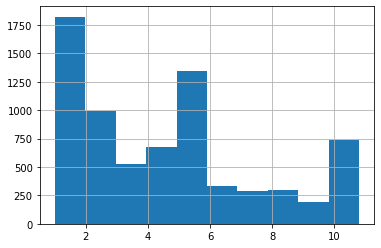

In [22]:
df_solar_3_scaled_w_category.loc[df_solar_3_scaled_w_category['category'] == 0]['capacity_mw'].hist()

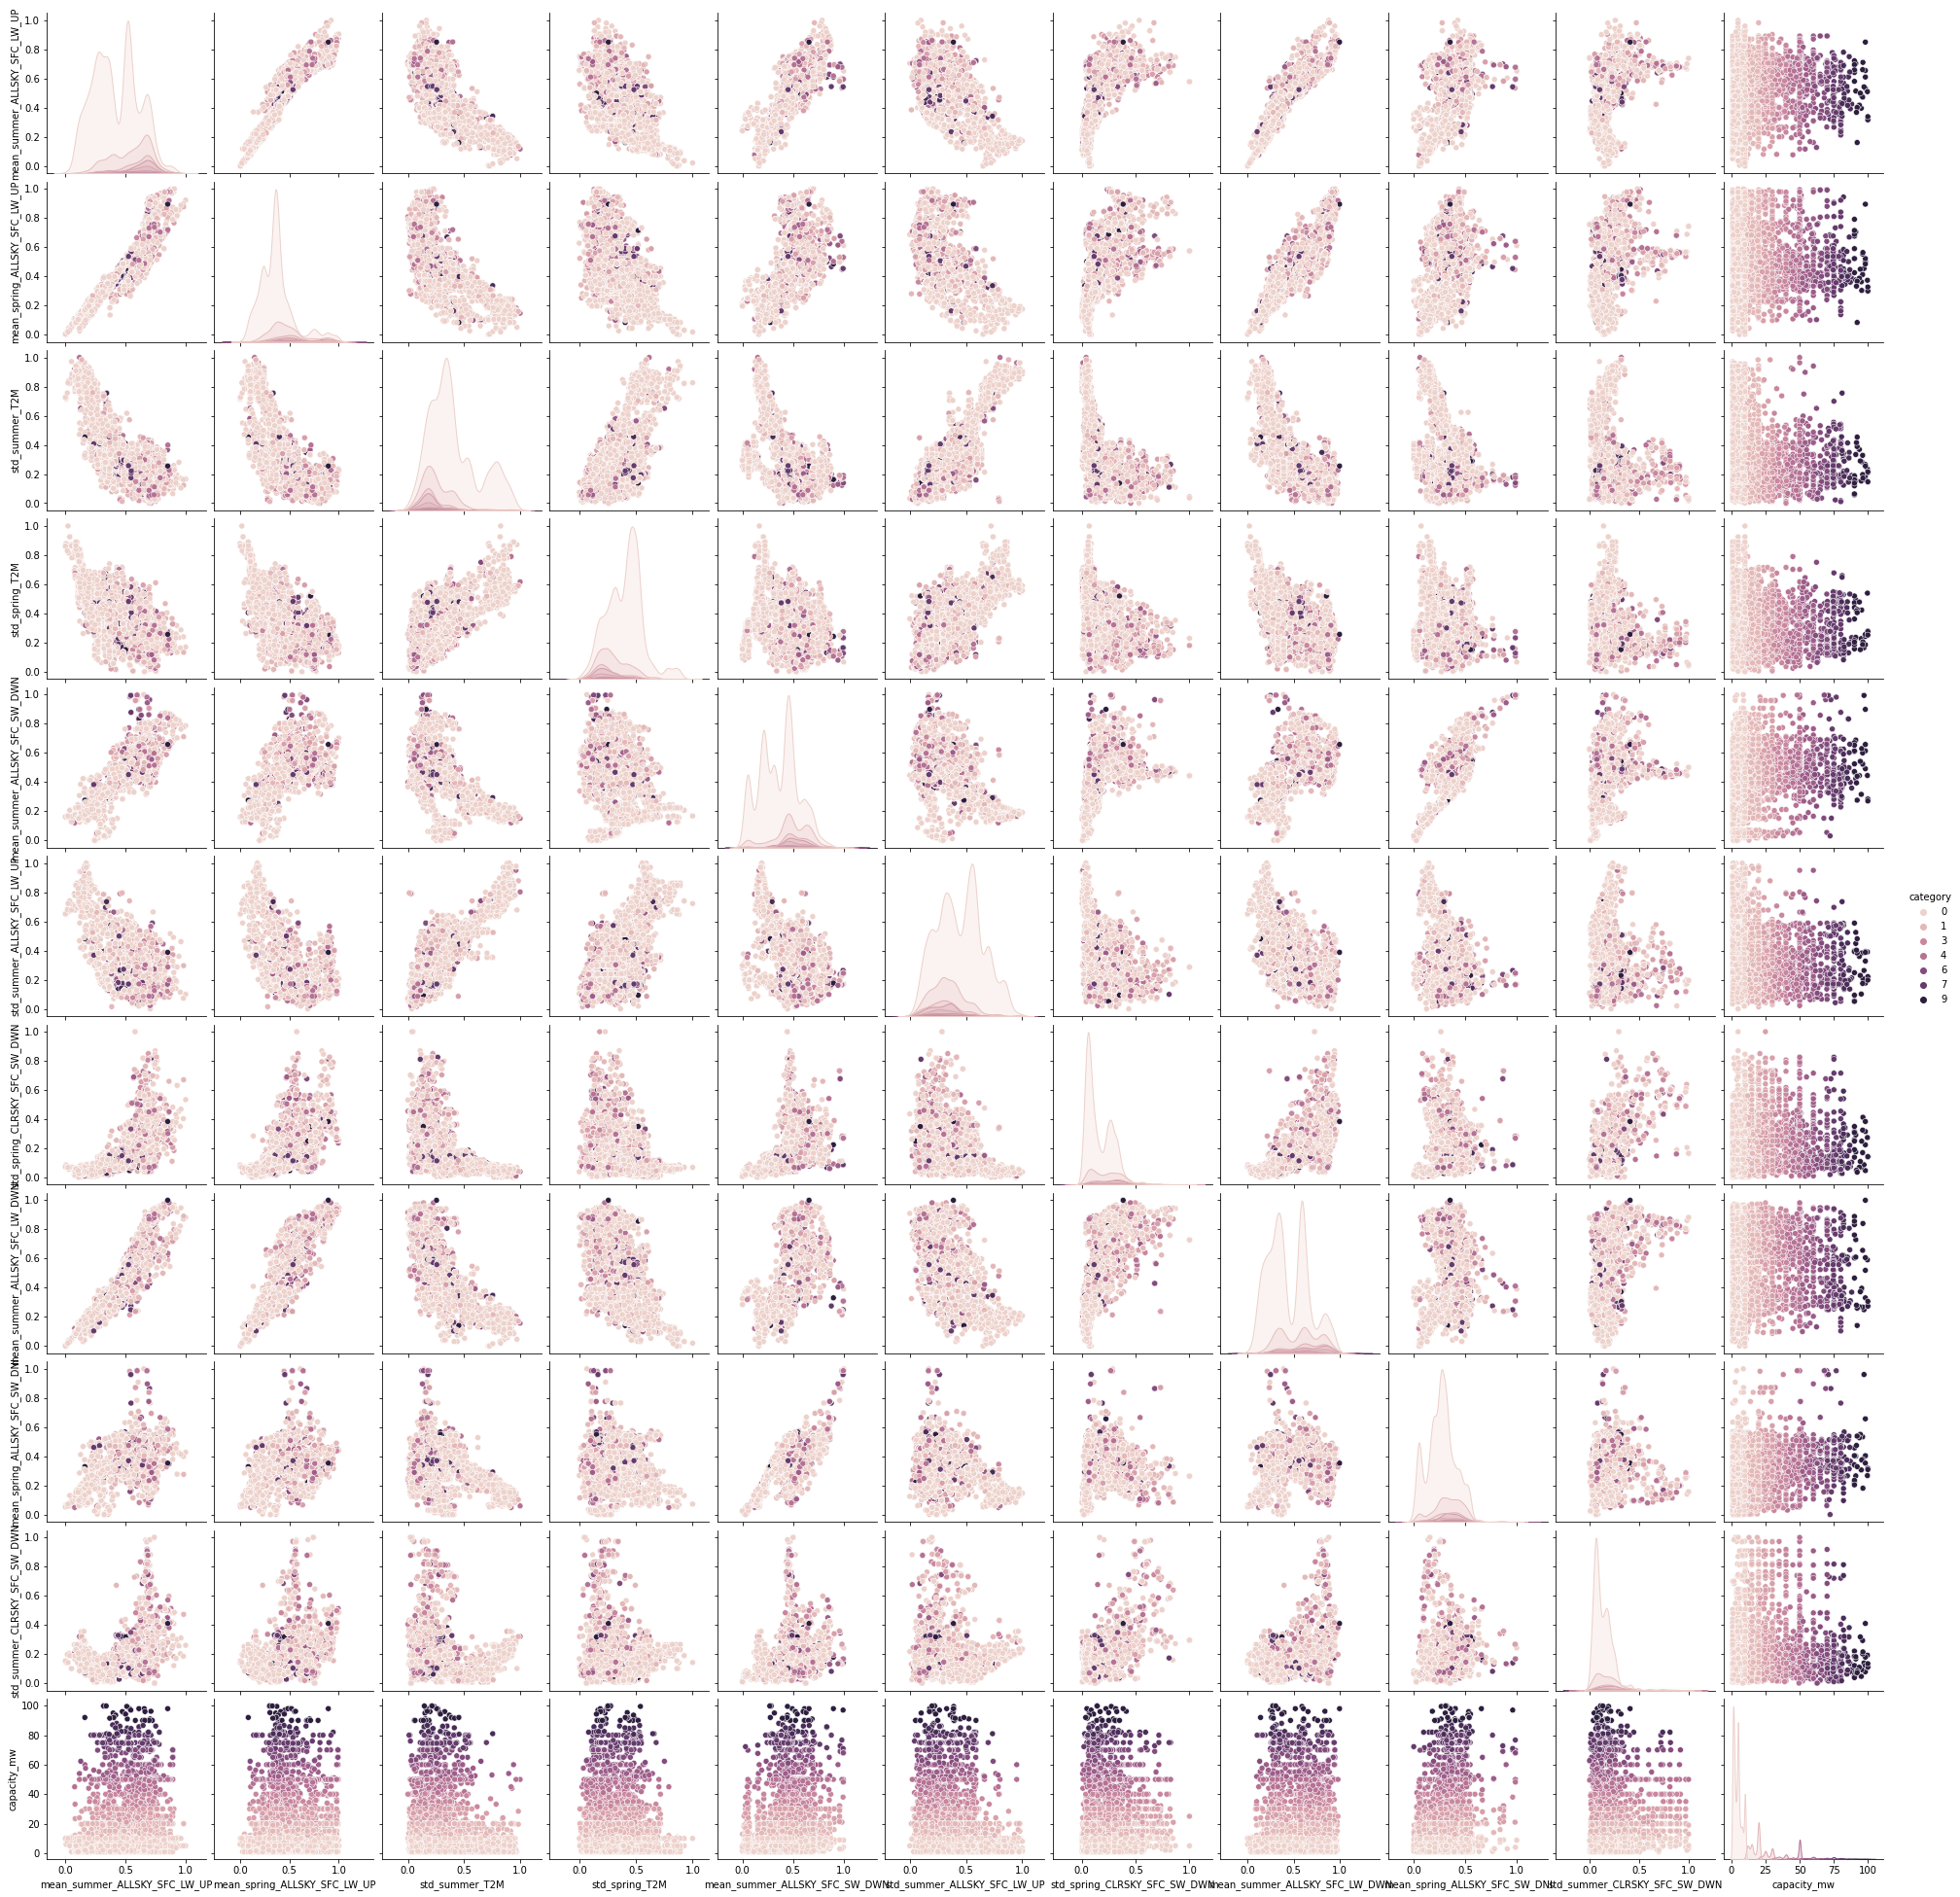

In [23]:
sns.pairplot(df_solar_3_scaled_w_category, hue='category')

<AxesSubplot:xlabel='capacity_mw', ylabel='generation_gwh_2013'>

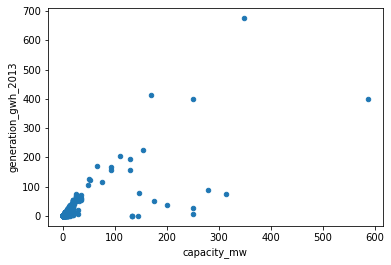

In [165]:
df_solar_2.plot.scatter(x='capacity_mw', y='generation_gwh_2013')

# LOOKING UP SPECIFIC THINGS

In [166]:
df_solar_2['generation_gwh_2013'].isna().sum()

0

In [167]:
# sns.pairplot(df_solar_2, hue="capacity_mw", height=2.5)

<AxesSubplot:>

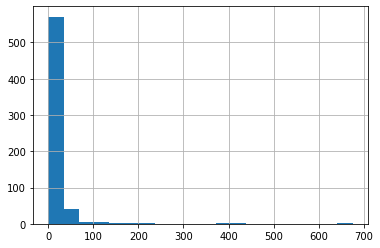

In [168]:
df_solar_2['generation_gwh_2013'].hist(bins=20)

541

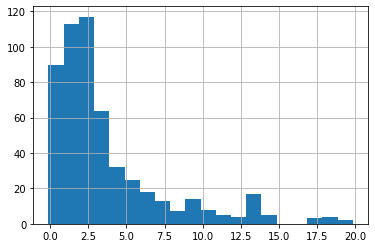

In [57]:
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].hist(bins=20)
df_solar_2[df_solar_2['generation_gwh_2013'] < 20]['generation_gwh_2013'].count()

76

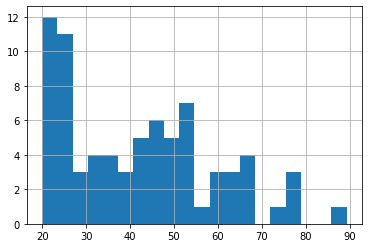

In [76]:
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].hist(bins=20)
df_solar_2.loc[(df_solar_2['generation_gwh_2013'] >= 20) & (df_solar_2['generation_gwh_2013'] < 100)]['generation_gwh_2013'].count()

14

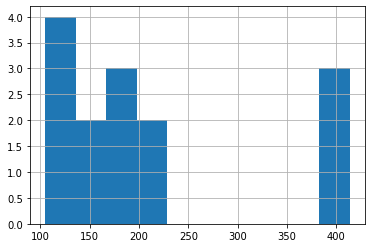

In [77]:
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].hist(bins=20)
# df_solar_2[df_solar_2['generation_gwh_2013'] > 100]['generation_gwh_2013'].count()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].hist()
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 100) & (df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

In [78]:
df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()

632

In [83]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

Int64Index([24873], dtype='int64', name='index')

In [87]:
df_solar_2.drop(df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)].index, inplace=True)

In [88]:
df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()

0

In [89]:
a = df_solar_2[(df_solar_2['generation_gwh_2013'] < 500)]['generation_gwh_2013'].count()
b = df_solar_2[(df_solar_2['generation_gwh_2013'] >= 500)]['generation_gwh_2013'].count()
f'{np.round(b/(a + b) * 100,2)}%'

'0.0%'

In [7]:
# df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 500)].copy()
df_solar_2 = df_solar_2[(df_solar_2['capacity_mw'] < 100)].copy()

In [17]:
# remove high values???
df_solar_2['capacity_mw'].sort_values(ascending= False)

index
20159    99.8
20910    99.8
20460    99.8
20380    99.8
1064     99.5
         ... 
16391     1.0
9787      1.0
32683     1.0
32684     1.0
32196     1.0
Name: capacity_mw, Length: 10316, dtype: float64

In [18]:
# df_solar.loc[18177, ["latitude", "longitude", "capacity_mw"]]

# X AND Y

In [45]:
X = df_solar_2013_best_k.drop(columns=['generation_gwh_2013'])
# X = df_solar_2[['capacity_mw']]
y = df_solar_2013_best_k['generation_gwh_2013']

In [46]:
X = X.reindex(sorted(X.columns), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 0)

# DECISION TREE REGRESSOR

50


<AxesSubplot:>

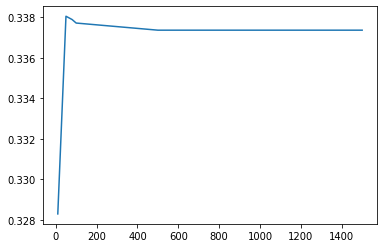

In [48]:
candidate_max_leaf_nodes = [10, 50, 80, 100, 500, 1200, 1500]
results = {}

results = {node: utils.get_accuracy_tree("regression",node, X_train, X_test, y_train, y_test) for node in candidate_max_leaf_nodes}
best_tree_size = max(results, key=results.get)
print(best_tree_size)
sns.lineplot(data=results, x= results.keys(), y= results.values())

In [49]:

# Define model. Specify a number for random_state to ensure same results each run
tree_model = DecisionTreeRegressor(random_state=1)

# Fit model
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

In [50]:
y_pred = tree_model.predict(X_test)

In [51]:

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

9.437799836395453
3310.4973340501906


In [52]:
tree_model.score(X_test, y_test)

0.331807033893988

(array([[1.447e+03, 2.890e+02, 1.080e+02, 4.200e+01, 9.200e+01, 2.600e+01,
         2.200e+01, 2.600e+01, 5.000e+00, 5.000e+00],
        [1.348e+03, 3.660e+02, 2.230e+02, 6.200e+01, 4.500e+01, 8.000e+00,
         1.000e+00, 6.000e+00, 1.000e+00, 2.000e+00]]),
 array([ 1.  , 10.88, 20.76, 30.64, 40.52, 50.4 , 60.28, 70.16, 80.04,
        89.92, 99.8 ]),
 <a list of 2 BarContainer objects>)

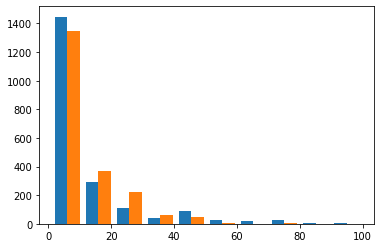

In [44]:
plt.hist([y_test, y_pred])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

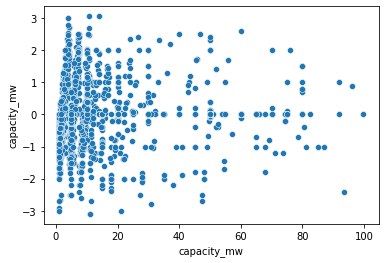

In [379]:
residuals = y_test - y_pred
sns.scatterplot(y_test, residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

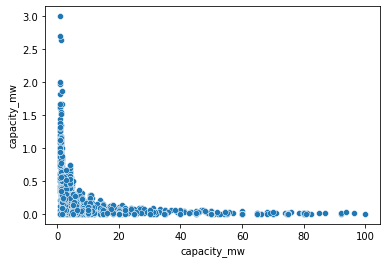

In [380]:
ap_residuals = np.abs(residuals) / y_test

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

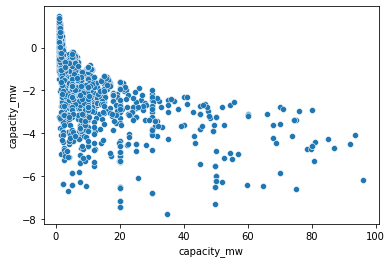

In [366]:
lap_residuals = np.log(ap_residuals)
sns.scatterplot(y_test, lap_residuals)

<BarContainer object of 2062 artists>

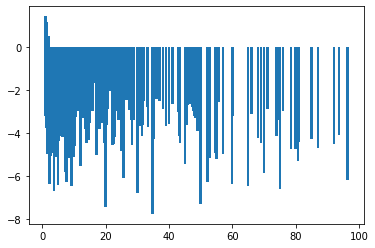

In [367]:
plt.bar(y_test, lap_residuals)

ValueError: supplied range of [-inf, 1.6486586255873816] is not finite

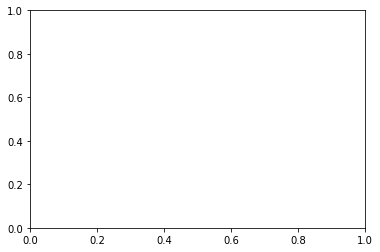

In [342]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# RANDOM FOREST REGRESSOR

In [47]:
# Numbers of trees
n_estimators = [int(x) for x in np.arange(10, 101, 10)]
# Numbers of features to consider at every split
# max_features = [1, "sqrt", "log2"]
# Maximum numbers of levels in tree
max_depth = [50, 100, 500]
# Minimum numbers of samples required to split a node
min_samples_split = [2, 10, 50 ]
# Minimum numbers of samples required at each leaf node
min_samples_leaf = [1, 10, 50, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]

max_leaf_nodes = [10, 100, 500]

param_grid = {
                'n_estimators': n_estimators,
                # 'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap,
                'max_leaf_nodes': max_leaf_nodes
            }



In [50]:

# rf_grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv=5, verbose = 2, n_jobs=4)
rf_grid = RandomizedSearchCV(estimator = RandomForestRegressor(), param_distributions = param_grid, n_iter = 10, cv=5, verbose = 2, n_jobs=4)

In [51]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=100, min_samples_leaf=50, min_samples_split=2, n_estimators=60; total time=   4.1s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=100, min_samples_leaf=50, min_samples_split=2, n_estimators=60; total time=   4.2s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=100, min_samples_leaf=50, min_samples_split=2, n_estimators=60; total time=   4.2s
[CV] END bootstrap=False, max_depth=100, max_leaf_nodes=100, min_samples_leaf=50, min_samples_split=2, n_estimators=60; total time=   4.6s
[CV] END bootstrap=True, max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2, n_estimators=80; total time=   2.5s
[CV] END bootstrap=True, max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2, n_estimators=80; total time=   2.6s
[CV] END bootstrap=True, max_depth=500, max_leaf_nodes=500, min_samples_leaf=100, min_samples_split=2, n_

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [50, 100, 500],
                                        'max_leaf_nodes': [10, 100, 500],
                                        'min_samples_leaf': [1, 10, 50, 100],
                                        'min_samples_split': [2, 10, 50],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   verbose=2)

In [52]:
rf_grid.best_params_

{'n_estimators': 80,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 100,
 'max_depth': 500,
 'bootstrap': True}

In [53]:
rf_grid.score(X_test, y_test)

0.34305437373937986

In [21]:
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

7.693299005672695


In [22]:
rf_model.score(X_test, y_test)

0.35108943258456393

(array([[1447.,  289.,  108.,   42.,   92.,   26.,   22.,   26.,    5.,
            5.],
        [1328.,  367.,  255.,   65.,   37.,    4.,    6.,    0.,    0.,
            0.]]),
 array([ 1.  , 10.88, 20.76, 30.64, 40.52, 50.4 , 60.28, 70.16, 80.04,
        89.92, 99.8 ]),
 <a list of 2 BarContainer objects>)

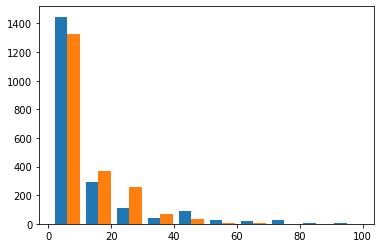

In [23]:
plt.hist([y_test, y_pred])

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

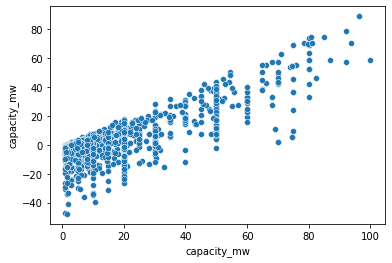

In [24]:
residuals = y_test - y_pred
ap_residuals = np.abs(residuals) / y_test
lap_residuals = np.log(ap_residuals)

sns.scatterplot(y_test, residuals)


/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

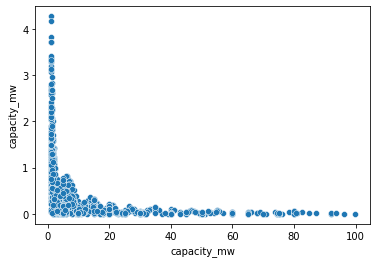

In [347]:

sns.scatterplot(y_test, ap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='capacity_mw', ylabel='capacity_mw'>

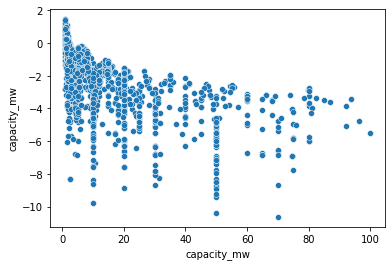

In [348]:

sns.scatterplot(y_test, lap_residuals)

/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:2052: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[0, 2] += tx
/home/tomas/renewable_power_plants/solar_wind_power_plants_prediction/env_renewable_power_plants_pred/lib/python3.8/site-packages/matplotlib/transforms.py:396: RuntimeWarning: invalid value encountered in double_scalars
  return (x0, y0, x1 - x0, y1 - y0)


<BarContainer object of 2062 artists>

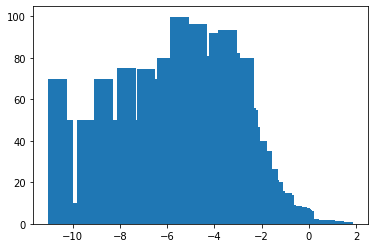

In [349]:
plt.bar(lap_residuals,y_test)

ValueError: supplied range of [-8.046314429606786, inf] is not finite

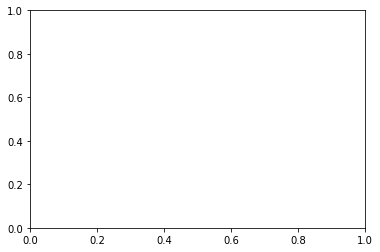

In [87]:
plt.hist(lap_residuals, bins=100, density=1, histtype='step', cumulative=True)

# LASSO, RIDGE, LINEAR REGRESSION

In [63]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train,y_train)

ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train,y_train)

linreg_model = LinearRegression()
linreg_model.fit(X_train,y_train)

y_pred = lasso_model.predict(X_test)
print("Lasso")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(lasso_model.score(X_test, y_test))

y_pred = linreg_model.predict(X_test)
print("Linear Regression")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(linreg_model.score(X_test, y_test)
)
y_pred = ridge_model.predict(X_test)
print("Ridge")
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(ridge_model.score(X_test, y_test))

Lasso
11.279597791902042
1715.7753988430914
0.653686761462497
Linear Regression
11.283837670722104
1715.9481165393915
0.6536519000087202
Ridge
11.27715940324643
1715.6491471580064
0.6537122441859131


# SCALLING

In [53]:
# X_train_normalized = stats.boxcox(X_train)
x = X_train.values #returns a numpy array
min_max_scaler = MinMaxScaler()
power_transformer = PowerTransformer(method='yeo-johnson')
standard_scaler = StandardScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_train_scaled = pd.DataFrame(x_scaled, index=X_train.index, columns=X_train.columns)

x = X_test.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_test_scaled = pd.DataFrame(x_scaled, index=X_test.index, columns=X_test.columns)

x = X.values #returns a numpy array
# x_scaled = min_max_scaler.fit_transform(x)
# x_scaled = power_transformer.fit_transform(x)
x_scaled = standard_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled, index=X.index, columns=X.columns)


# KNN

7


<AxesSubplot:>

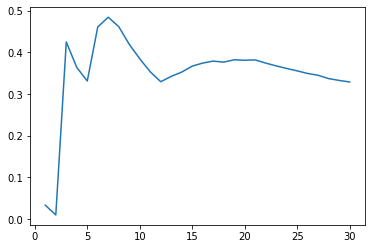

In [54]:
candidate_n_neighbors = np.arange(1,31)
results = {}

# results = {n: utils.get_accuracy_knn(n, X_train_scaled_pca, X_test_scaled_pca, y_train, y_test) for n in candidate_n_neighbors}
results = {n: utils.get_accuracy_knn("regression",n, X_train, X_test, y_train, y_test) for n in candidate_n_neighbors}
best_n_neighbors = max(results, key=results.get)
print(best_n_neighbors)
sns.lineplot(data=results, x= results.keys(), y= results.values())

# POLYNOMIAL FEATURES

In [18]:
polynomial_features = PolynomialFeatures(2)
polynomial_features.fit_transform(X)

array([[1.00000000e+00, 4.49111111e+00, 4.63722222e+00, ...,
        8.04232881e+04, 1.47592840e+03, 2.70862420e+01],
       [1.00000000e+00, 4.49111111e+00, 4.63722222e+00, ...,
        8.04232881e+04, 1.47592840e+03, 2.70862420e+01],
       [1.00000000e+00, 7.28666667e+00, 7.74888889e+00, ...,
        1.75105982e+05, 3.04101759e+03, 5.28125188e+01],
       ...,
       [1.00000000e+00, 3.12888889e+00, 4.92444444e+00, ...,
        1.34433445e+05, 1.90373693e+03, 2.69591716e+01],
       [1.00000000e+00, 2.96000000e+00, 5.55000000e+00, ...,
        1.60812585e+05, 2.34994464e+03, 3.43396000e+01],
       [1.00000000e+00, 6.31333333e+00, 7.94055556e+00, ...,
        1.47258946e+05, 2.97251850e+03, 6.00022373e+01]])

In [55]:
model_scaled_poly_knn = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(2),
    KNeighborsRegressor(n_neighbors = 7)
)

model_scaled_poly_knn.fit(X_train, y_train)
model_scaled_poly_knn.score(X_test, y_test)

0.48014050421776777

In [56]:
results = cross_validate(KNeighborsRegressor(n_neighbors = 7), X, y, cv=5)
results

{'fit_time': array([0.00541782, 0.002913  , 0.00248027, 0.00312042, 0.00251007]),
 'score_time': array([0.00694609, 0.00357509, 0.00413108, 0.0025382 , 0.00459719]),
 'test_score': array([ 0.34788596, -5.82901997,  0.283046  ,  0.85094995,  0.65519775])}

# VALIDATION AND LEARNING CURVE
https://scikit-learn.org/stable/modules/learning_curve.html

In [57]:
train_scores, test_scores = validation_curve(
    KNeighborsRegressor(),
    X,
    y,
    param_name = "n_neighbors",
    param_range = candidate_n_neighbors,
    cv = 5
)

In [58]:
np.mean(train_scores, axis=1)

array([0.99603509, 0.75168652, 0.66615114, 0.63599121, 0.59117091,
       0.5646531 , 0.55936474, 0.54396934, 0.53309898, 0.52293377,
       0.52256843, 0.51803793, 0.51201283, 0.50189192, 0.49547082,
       0.49379333, 0.4916418 , 0.49226315, 0.49120939, 0.48610361,
       0.48268502, 0.47889529, 0.47477685, 0.46971957, 0.46474712,
       0.4601171 , 0.45394427, 0.44971848, 0.4452805 , 0.43999055])

In [59]:
candidate_n_neighbors.shape[0]

30

([<matplotlib.axis.XTick at 0x7fa9ae41abb0>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30')])

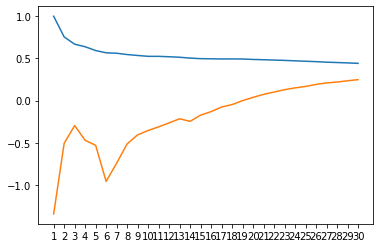

In [60]:
plt.plot(np.mean(train_scores, axis=1))
plt.plot(np.mean(test_scores, axis=1))
plt.xticks(np.arange(candidate_n_neighbors.shape[0]), candidate_n_neighbors)

In [61]:
lc = learning_curve(Lasso(alpha=0.01), X, y, cv=5)
# lc = learning_curve(KNeighborsRegressor(n_neighbors = 7), X, y, cv=5)
samples, train, test = lc[0], lc[1], lc[2]

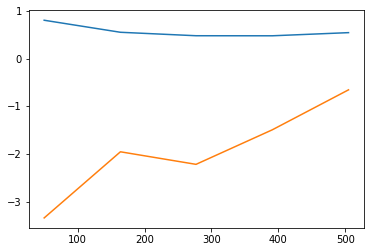

In [62]:
plt.plot(samples, np.mean(train, axis=1))
plt.plot(samples, np.mean(test, axis=1))